# "Analysis of an A/B Test for an Improved Recommendation System in an Online Store"

The online store launched an A/B test called "recommender_system_test" in December 2020 to test changes related to the introduction of an improved recommendation system. The test had two groups: the control group (Group A) and the test group (Group B) which implemented a new payment funnel. The expected result of the test was to see a 10% increase in conversion at each stage of the funnel, including product page views, instances of adding items to the shopping cart, and purchases, within 14 days of signing up. The audience for the test was 15% of new users from the EU region.

The project was launched on December 7, 2020 and stopped taking up new users on December 21, 2020. The end date of the project was January 1, 2021. The expected number of test participants was 6000.

The project had several data files:

+ ab_project_marketing_events_us.csv - a calendar of marketing events for 2020
+ final_ab_new_users_upd_us.csv - all users who signed up in the online store from December 7 to 21, 2020
+ final_ab_events_upd_us.csv - all events of the new users within the period from December 7, 2020 through January 1, 2021
+ final_ab_participants_upd_us.csv - table containing test participants

To complete the task,I need to analyze the test results and ensure that it was carried out correctly. I should explore the data to see whether types need to be converted, and whether there are any missing or duplicate values. Once I have a clean dataset, analyze the data to determine whether there were significant differences between the control and test groups.

To start, import the necessary libraries and read in the data frames:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from datetime import timedelta
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import plotly.graph_objects as go
from scipy.stats import kruskal





In [2]:
pip install -U kaleido

     |████████████████████████████████| 79.9 MB 264 kB/s eta 0:00:012
Note: you may need to restart the kernel to use updated packages.


In [3]:

marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
logs = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')


### Data preprocessing

Checking the dimensions of each data frame to make sure they were loaded properly:

In [4]:
print('Marketing events:', marketing_events.shape)
print('New users:', new_users.shape)
print('Logs:', logs.shape)
print('Participants:', participants.shape)


Marketing events: (14, 4)
New users: (58703, 4)
Logs: (423761, 4)
Participants: (14525, 3)


Take a look at the first few rows of each data frame and get a sense of what the data looks like:

In [5]:
marketing_events.head(20)



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [6]:
new_users.sample(10)

,user_id,first_date,region,device
27110,7C9CAF5B91BDEAA6,2020-12-09,EU,iPhone
49841,A4C0DDFA042944B9,2020-12-19,EU,Mac
23127,607D89F816CBF890,2020-12-22,N.America,Android
19790,984E2816E84A9FF6,2020-12-08,EU,Android
12416,747A06D4FCA154ED,2020-12-21,EU,Android
32037,A730D86F11A4D5C2,2020-12-23,EU,Android
36845,DCDD64F64EB07773,2020-12-17,N.America,Android
28168,EEA65A9198540900,2020-12-16,APAC,Android
54945,0B483D31D2F68B45,2020-12-20,EU,PC
25064,C5FC861871F4B750,2020-12-22,EU,PC


In [7]:
logs.sample(10)

,user_id,event_dt,event_name,details
118742,A75CC29788B4893A,2020-12-28 18:22:25,product_cart,NaN
124430,4B7CAC9904783A2D,2020-12-08 01:53:52,product_page,NaN
346835,54067F3A01A67A1B,2020-12-20 08:24:09,login,NaN
394782,DBB19993FE73EAD5,2020-12-23 03:18:58,login,NaN
91889,D211793E9C939DF0,2020-12-19 12:12:21,product_cart,NaN
187578,140983468780190D,2020-12-19 05:10:44,product_page,NaN
364610,C9A8A7D68D10888F,2020-12-21 08:24:54,login,NaN
212081,103C70534A6794C1,2020-12-22 04:18:42,product_page,NaN
62670,61C70F2246AA34A1,2020-12-08 17:59:23,product_cart,NaN
335941,02BF21C48BA199CA,2020-12-19 03:27:38,login,NaN


In [8]:
participants.sample(10)

,user_id,group,ab_test
7559,6C13D3DFA54BECD9,B,interface_eu_test
14069,D457122017FABF9E,A,interface_eu_test
8859,AC2DC3CFD7D81D94,A,interface_eu_test
3847,89B602D3FEC47623,B,interface_eu_test
12754,3DBDB47704D61EFB,B,interface_eu_test
6212,270BFCF7D4DCD4B3,B,interface_eu_test
10708,1E88BC8288922021,B,interface_eu_test
9119,D08DF29768D5C804,A,interface_eu_test
6744,6A6D43C71AEF749E,B,interface_eu_test
1207,C37FDEAD2E788A6F,A,recommender_system_test


Check the structure of each data frame to understand the types of data in each column:



In [9]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Convert the values in the 'start_dt' and 'finish_dt' columns to datetime objects. Once these columns are converted, It's possible to use them for various date-based operations, such as filtering data based on specific dates or calculating time differences. 

In [10]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])


In [11]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [12]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


Convert the datatype of the 'first_date' column from object to datetime

In [13]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])


In [14]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


Convert the datatype of the 'event_dt' column from object to datetime

In [15]:

logs['event_dt'] = pd.to_datetime(logs['event_dt'])


In [16]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [17]:
def print_data_quality(dataframes):
    '''The function takes a dictionary of pandas dataframes as input and prints the number of
    null values and duplicated rows for each dataframe in the dictionary.'''
    for name, df in dataframes.items():
        print(f"Null values in {name}:")
        print(df.isnull().sum())
        print(f"Duplicated rows in {name}:")
        print(df.duplicated().sum())
        print("\n")


In [18]:
dataframes = {
    "marketing_events": marketing_events,
    "new_users": new_users,
    "logs": logs,
    "participants": participants
}

print_data_quality(dataframes)


Null values in marketing_events:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Duplicated rows in marketing_events:
0


Null values in new_users:
user_id       0
first_date    0
region        0
device        0
dtype: int64
Duplicated rows in new_users:
0


Null values in logs:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
Duplicated rows in logs:
0


Null values in participants:
user_id    0
group      0
ab_test    0
dtype: int64
Duplicated rows in participants:
0




In [19]:
logs['details'].isna().mean() * 100


85.76697714041642

In [20]:
logs_filt=logs.query("event_name == 'purchase'")
logs_filt

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
60309,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
60310,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
60311,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
60312,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


In [21]:
logs_filt['details'].isna().mean() * 100

0.0

The column 'details' in logs contains 85% missing values.The missing data is due to the fact that the details in the column are only about the purchase made (price), while all the other events don't have this value. I can drop the column or just ignore it, since it is not relevant to my analysis.


In [22]:
#logs = logs.drop('details', axis=1)

### EDA

Let's begin with understanding the data and doing some exploratory analysis.


In [23]:
def print_df_info(df_list):
    for name, df in df_list:
        print("Dataframe Name: ", name)
        print(df.info())

df_list = [
    ("marketing_events", marketing_events),
    ("new_users", new_users),
    ("logs", logs),
    ("participants", participants)
]

print_df_info(df_list)


Dataframe Name:  marketing_events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
Dataframe Name:  new_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None
Dataframe Name:  logs
<cla

The technical requirements for the test were the following:

- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- 15% of new users from EU
- Expected number of test participants: 6000

Let's see if the technical requirement were met.


Number of participants to the 'recomender system' test: 

In [24]:
participants.query('ab_test== "recommender_system_test"').user_id.nunique()

3675

In [25]:
merged_df = participants.merge(new_users, on='user_id', how='outer')


To find the percentage of users from the EU who take part in the recommender_system_test, first filter the merged dataframe to include only users from the EU who took part in the test, and then calculate the percentage:

In [26]:
merged_df.first_date.max()

Timestamp('2020-12-23 00:00:00')

<div class="alert alert-info"> 
<b>take into account the following moment: the registration dates of all users from EU must equal the registration dates participating in the test (i.e., from December 07 to December 21).</b> 

In [27]:
merged_eu_dates=merged_df.query("(region == 'EU') & ('2020-12-07' <= first_date <= '2020-12-20')")


In [28]:
merged_df

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,DABC14FDDFADD29E,A,interface_eu_test,2020-12-08,EU,Mac
4,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
...,...,...,...,...,...,...
59585,F4BEEB17FEF0D52A,NaN,NaN,2020-12-20,EU,PC
59586,1DB53B933257165D,NaN,NaN,2020-12-20,EU,Android
59587,538643EB4527ED03,NaN,NaN,2020-12-20,EU,Mac
59588,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC


In [29]:
eu_participants = merged_df[(merged_df['region'] == 'EU') & (merged_df['ab_test'] == 'recommender_system_test')]
eu_participation_rate = len(eu_participants) / len(merged_eu_dates) * 100


In [30]:
eu_participation_rate

9.730530552915525

So, we don't have an audience made of 15% of new_users from EU, but 9.73%

In [31]:
merged_logs_df = merged_df.merge(logs, on='user_id', how='outer')


In [32]:
merged_logs_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...,...,...,...,...,...
429471,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-24 21:55:35,product_page,NaN
429472,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-20 02:23:24,login,NaN
429473,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-24 21:55:35,login,NaN
429474,8F04273BB2860229,NaN,NaN,2020-12-20,EU,Android,2020-12-20 03:17:17,product_cart,NaN


In [33]:
recommender_df = merged_logs_df[merged_logs_df['ab_test'] == 'recommender_system_test']


This will create a new dataframe that includes only the rows where the ab_test column is equal to recommender_system_test. I will then use this dataframe for further analysis.


In [34]:
recommender_df.sample(10)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
29522,D1BB8F37D28A0BD3,B,recommender_system_test,2020-12-11,APAC,Android,2020-12-14 12:27:08,login,NaN
25134,37094134968B2013,B,recommender_system_test,2020-12-16,EU,PC,2020-12-16 18:51:44,purchase,4.99
6244,ABDE941B896D8119,A,recommender_system_test,2020-12-09,EU,PC,2020-12-28 20:17:02,login,NaN
17415,B85F36F6515DAB84,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 12:19:00,product_cart,NaN
5829,3371DE0844B9CDC8,A,recommender_system_test,2020-12-19,EU,PC,2020-12-19 02:33:47,product_page,NaN
9234,68E46B7897232BBF,A,recommender_system_test,2020-12-20,EU,Mac,2020-12-27 09:11:58,login,NaN
12930,B1EC1816EEDF7C5C,A,recommender_system_test,2020-12-16,EU,PC,2020-12-16 22:40:52,product_page,NaN
28910,245BD962FFBC57F0,A,recommender_system_test,2020-12-19,N.America,PC,2020-12-27 15:38:40,login,NaN
25836,EEFDF8577ED817C0,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-24 06:55:32,login,NaN
21756,D439FE97E8B225CA,B,recommender_system_test,2020-12-16,EU,iPhone,2020-12-20 12:00:02,login,NaN


In [35]:
min_date = recommender_df['event_dt'].min()
print(min_date)

2020-12-07 00:05:57


In [36]:
max_date = recommender_df['event_dt'].max()
print(max_date)

2020-12-30 12:42:57


***The technical requirements were not satisfied in full: the amount of new users from EU is 7.8% and the logs we have available stop the day 30 of december, 2 days before. I'll conduct the analysis, but the results could differ in accuracy from what was expected.***


In [37]:
recommender_df.user_id.nunique()

3675

also, the are much less participants than expected.


In [38]:
recommender_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...,...,...,...,...,...
29619,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN
29620,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN
29621,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN
29622,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN


In [39]:
# Calculate the lifetime of each event
recommender_df['lifetime'] = recommender_df['event_dt'] - recommender_df['first_date']

# Filter out events with lifetime greater than 14 days
recommender_df = recommender_df[recommender_df['lifetime'] <= pd.Timedelta('14 days')]



/tmp/ipykernel_169/860644233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_df['lifetime'] = recommender_df['event_dt'] - recommender_df['first_date']


<div class="alert alert-block alert-success">
<b>Reviewer's comment v.2</b> 
    
👍 Perfect! Thank you for considering this point!
</div>

In [40]:
recommender_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06
...,...,...,...,...,...,...,...,...,...,...
29619,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN,0 days 10:12:15
29620,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN,1 days 22:51:16
29621,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN,2 days 02:28:03
29622,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN,3 days 22:55:14


In [41]:

recommender_df['lifetime_days'] = recommender_df['lifetime'].dt.days


/tmp/ipykernel_169/2103061893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommender_df['lifetime_days'] = recommender_df['lifetime'].dt.days


In [42]:
# perform ANOVA test
group_a_lifetime = recommender_df[recommender_df['group'] == 'A']['lifetime_days']
group_b_lifetime = recommender_df[recommender_df['group'] == 'B']['lifetime_days']
f_value, p_value = f_oneway(group_a_lifetime, group_b_lifetime) 

# print the ANOVA test results and group statistics
print(f'F-value: {f_value:.3f}')
print(f'p-value: {p_value:.3f}')
print('Group A mean lifetime:', round(group_a_lifetime.mean(), 2))
print('Group A standard deviation:', round(group_a_lifetime.std(), 2))
print('Group B mean lifetime:', round(group_b_lifetime.mean(), 2))
print('Group B standard deviation:', round(group_b_lifetime.std(), 2))

# interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the mean lifetime between the groups.")
else:
    print("There is not enough evidence to conclude that there is a significant difference in the mean lifetime between the groups.")


F-value: 4.787
p-value: 0.029
Group A mean lifetime: 2.74
Group A standard deviation: 3.26
Group B mean lifetime: 2.63
Group B standard deviation: 3.32
There is a statistically significant difference in the mean lifetime between the groups.


Based on the results, we can conclude that there is a statistically significant difference in the mean lifetime between at least one pair of groups, with a p-value of 0.029. The F-value of 4.787 indicates that there is a difference in the variance of the lifetime between the groups. However, the effect size is small, as the difference in mean lifetime between Group A (2.74 days) and Group B (2.63 days) is not very large, and the standard deviations are similar. Therefore, further investigation may be necessary to determine the practical significance of these differences.

The ANOVA test assumes that the distribution of the response variable (lifetime in this case) is approximately normal for each group. If the distribution of lifetime is significantly non-normal in one or both groups, this assumption may be violated and the results of the ANOVA test may not be reliable.

In this case, we can visually inspect the distribution of lifetime in each group using a histogram or other plot. If the distribution is highly skewed or has outliers, we may consider using non-parametric tests such as the Kruskal-Wallis

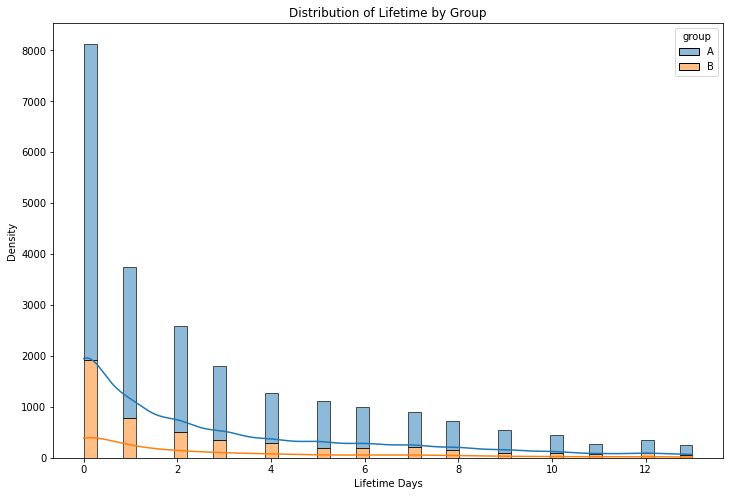

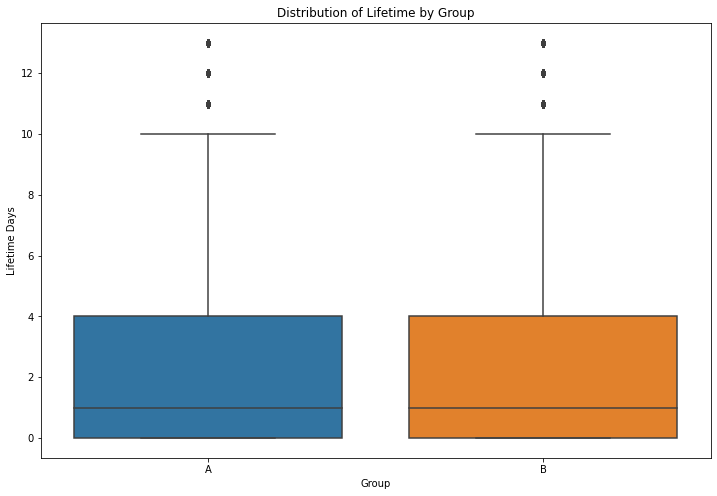

In [43]:
# plot the distribution of lifetime for each group using a histogram
sns.histplot(data=recommender_df, x='lifetime_days', hue='group', kde=True, multiple='stack')
plt.title('Distribution of Lifetime by Group')
plt.xlabel('Lifetime Days')
plt.ylabel('Density')
plt.gcf().set_size_inches(12, 8)
plt.show()

# plot the distribution of lifetime for each group using a box plot
sns.boxplot(data=recommender_df, x='group', y='lifetime_days')
plt.title('Distribution of Lifetime by Group')
plt.xlabel('Group')
plt.ylabel('Lifetime Days')
plt.gcf().set_size_inches(12, 8)
plt.show()


The distribution is not normal.

The Kruskal-Wallis test is a non-parametric test that compares the medians of two or more independent samples to determine if there are significant differences between them. 

In [44]:

# Perform Kruskal-Wallis test
stat, p_value = kruskal(recommender_df[recommender_df['group'] == 'A']['lifetime_days'], 
                        recommender_df[recommender_df['group'] == 'B']['lifetime_days'])

# Print the test results
print(f'Statistic: {stat}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the mean lifetime between the groups.")
else:
    print("There is not enough evidence to conclude that there is a significant difference in the mean lifetime between the groups.")


Statistic: 19.010984826552185
p-value: 1.2996808606666175e-05
There is a statistically significant difference in the mean lifetime between the groups.


so, there's a difference in the lifetime of the events between the groups

#### Study conversion at different funnel stages

In [45]:
# Filter the dataframe to only include group A and B users
group_a_df = recommender_df[recommender_df['group'] == 'A']
group_b_df = recommender_df[recommender_df['group'] == 'B']

# Calculate the number of unique users in each group
group_a_users = set(group_a_df['user_id'])
group_b_users = set(group_b_df['user_id'])

# Calculate the total number of users in each group
group_a_total = len(group_a_users)
group_b_total = len(group_b_users)

# Calculate the number of users who reached each stage of the funnel
group_a_login = len(set(group_a_df[group_a_df['event_name'] == 'login']['user_id']))
group_b_login = len(set(group_b_df[group_b_df['event_name'] == 'login']['user_id']))

group_a_product_page = len(set(group_a_df[group_a_df['event_name'] == 'product_page']['user_id']))
group_b_product_page = len(set(group_b_df[group_b_df['event_name'] == 'product_page']['user_id']))

group_a_product_cart = len(set(group_a_df[group_a_df['event_name'] == 'product_cart']['user_id']))
group_b_product_cart = len(set(group_b_df[group_b_df['event_name'] == 'product_cart']['user_id']))

group_a_purchase = len(set(group_a_df[group_a_df['event_name'] == 'purchase']['user_id']))
group_b_purchase = len(set(group_b_df[group_b_df['event_name'] == 'purchase']['user_id']))

# Calculate the conversion rates for each stage of the funnel
group_a_login_rate = group_a_login / group_a_total
group_b_login_rate = group_b_login / group_b_total

group_a_product_page_rate = group_a_product_page / group_a_total
group_b_product_page_rate = group_b_product_page / group_b_total

group_a_product_cart_rate = group_a_product_cart / group_a_total
group_b_product_cart_rate = group_b_product_cart / group_b_total

group_a_purchase_rate = group_a_purchase / group_a_total
group_b_purchase_rate = group_b_purchase / group_b_total

# Print the results
print('Group A Conversion Rates')
print('Login:', group_a_login_rate)
print('Product Page:', group_a_product_page_rate)
print('Product Cart:', group_a_product_cart_rate)
print('Purchase:', group_a_purchase_rate)

print('Group B Conversion Rates')
print('Login:', group_b_login_rate)
print('Product Page:', group_b_product_page_rate)
print('Product Cart:', group_b_product_cart_rate)
print('Purchase:', group_b_purchase_rate)


Group A Conversion Rates
Login: 1.0
Product Page: 0.6479796141244994
Product Cart: 0.2999635966508919
Purchase: 0.3174372042227885
Group B Conversion Rates
Login: 0.9989224137931034
Product Page: 0.5635775862068966
Product Cart: 0.27478448275862066
Purchase: 0.27586206896551724


This code calculates the number of unique users in each group, the total number of users in each group, and the number of users who reached each stage of the funnel. Then it calculates the conversion rates for each stage of the funnel by dividing the number of users who reached that stage by the total number of users in that group. Finally, it prints the conversion rates for each stage of the funnel for both groups.

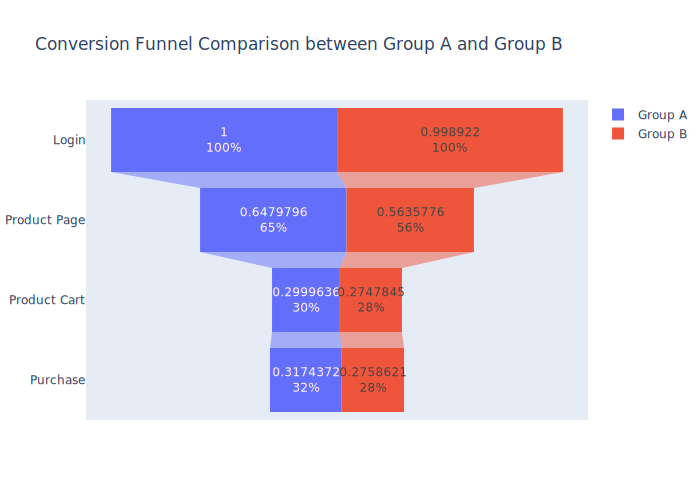

In [46]:

# Create the funnel visualization
fig = go.Figure(go.Funnel(
    y=['Login','Product Page', 'Product Cart', 'Purchase'],
    x=[group_a_login_rate,group_a_product_page_rate, group_a_product_cart_rate, group_a_purchase_rate],
    name='Group A',
    textinfo="value+percent initial"))

fig.add_trace(go.Funnel(
    y=['Login','Product Page', 'Product Cart', 'Purchase'],
    x=[ group_b_login_rate,group_b_product_page_rate, group_b_product_cart_rate, group_b_purchase_rate],
    name='Group B',
    textinfo="value+percent initial"))

fig.update_layout(title='Conversion Funnel Comparison between Group A and Group B')

fig.show(renderer="svg")


It seems that the control group has higher conversion rates at each stage of the funnel. All the users from B who get to the cart also purchase the product. We see instead a higher purchase rate than product cart rate. Maybe there's a link or button to buy instantly.

#### Is the number of events per user distributed equally in the samples?

In [47]:
recommender_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime,lifetime_days
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06,0
...,...,...,...,...,...,...,...,...,...,...,...
29619,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN,0 days 10:12:15,0
29620,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN,1 days 22:51:16,1
29621,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN,2 days 02:28:03,2
29622,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN,3 days 22:55:14,3


In [48]:
# Group the data by user and group, and count the number of events for each user in each group
event_counts = recommender_df.groupby(['user_id', 'group'])['event_name'].count()

# Print the event counts for each user in each group
print(event_counts)

user_id           group
001064FEAAB631A1  B         6
0010A1C096941592  A        12
00341D8401F0F665  A         2
003DF44D7589BBD4  A        15
00505E15A9D81546  A         5
                           ..
FF5B24BCE4387F86  A         9
FF825C1D791989B5  A         8
FF8CF7057415EB29  B         2
FFAE9489C76F352B  A         6
FFF28D02B1EACBE1  B         9
Name: event_name, Length: 3675, dtype: int64


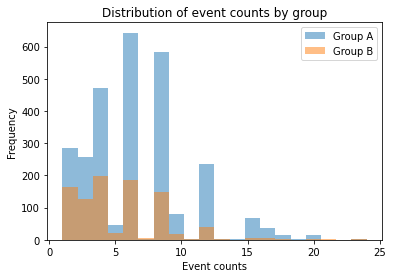

In [49]:
import matplotlib.pyplot as plt

# Separate the event counts for each group into separate Series
event_counts_a = event_counts.loc[:, 'A']
event_counts_b = event_counts.loc[:, 'B']

# Create a histogram of the event counts for group A
plt.hist(event_counts_a, bins=20, alpha=0.5, label='Group A')

# Create a histogram of the event counts for group B
plt.hist(event_counts_b, bins=20, alpha=0.5, label='Group B')

# Add labels and legend to the plot
plt.xlabel('Event counts')
plt.ylabel('Frequency')
plt.title('Distribution of event counts by group')
plt.legend()

# Show the plot
plt.show()


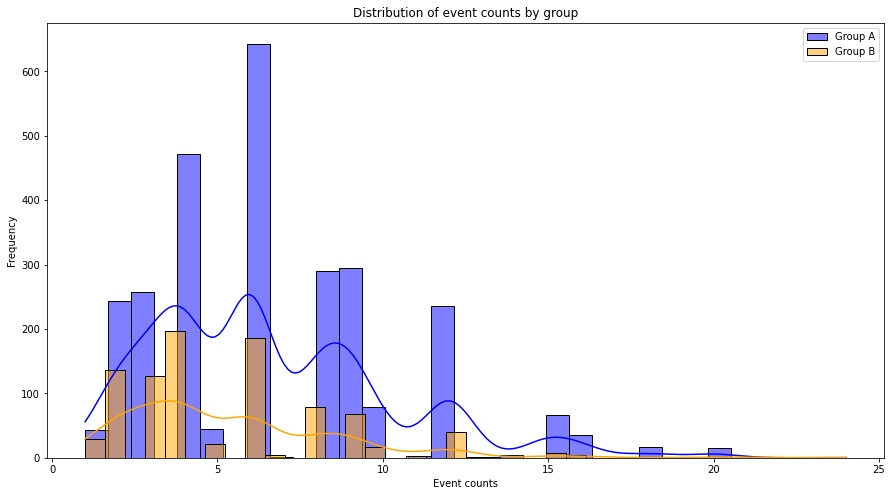

In [50]:
# Plot the distribution of the number of events per user for both groups
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=group_a_df, x=group_a_df.groupby('user_id').count()['event_name'], kde=True, alpha=0.5, label='Group A', color='blue')
sns.histplot(data=group_b_df, x=group_b_df.groupby('user_id').count()['event_name'], kde=True, alpha=0.5, label='Group B', color='orange')
plt.xlabel('Event counts')
plt.ylabel('Frequency')
plt.title('Distribution of event counts by group')

plt.legend()
plt.show()


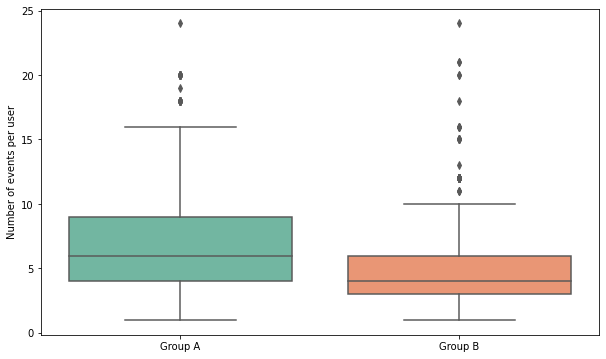

In [51]:

# Plot the distribution of the number of events per user for both groups using box plots
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=[group_a_df.groupby('user_id').count()['event_name'], group_b_df.groupby('user_id').count()['event_name']], palette='Set2')
ax.set_xticklabels(['Group A', 'Group B'])
ax.set_ylabel('Number of events per user')
plt.show()


In [52]:
# Calculate the mean and standard deviation of the event counts per user per group
mean_event_counts = event_counts.groupby('group').mean()
median_event_counts = event_counts.groupby('group').median()
std_event_counts = event_counts.groupby('group').std()

# Print the mean and standard deviation of the event counts per user per group
print(mean_event_counts)
print(median_event_counts)
print(std_event_counts)


group
A    6.614853
B    5.366379
Name: event_name, dtype: float64
group
A    6
B    4
Name: event_name, dtype: int64
group
A    3.663491
B    3.222666
Name: event_name, dtype: float64


It seems that there's a difference in the distribution.

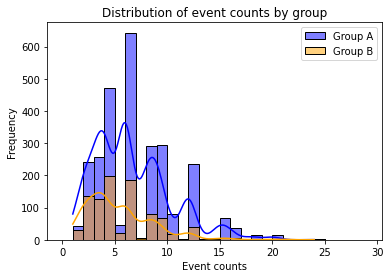

In [53]:
# The reviewer's cell
sns.histplot(data=group_a_df, x=group_a_df.groupby('user_id').count()['event_name'], 
             kde=True, alpha=0.5, label='Group A', color='blue',
             bins = np.arange(0,30,1))
sns.histplot(data=group_b_df, x=group_b_df.groupby('user_id').count()['event_name'], 
             kde=True, alpha=0.5, label='Group B', color='orange',
             bins = np.arange(0,30,1))
plt.xlabel('Event counts')
plt.ylabel('Frequency')
plt.title('Distribution of event counts by group')

plt.legend()
plt.show()


let's see if the distribution of events per user in the two groups is statistically different

In [54]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on group A
statistic, p_value = shapiro(group_a_df.groupby('user_id').count()['event_name'])
print(f"Group A: Shapiro-Wilk test statistic = {statistic}, p-value = {p_value}")

# Perform Shapiro-Wilk test on group B
statistic, p_value = shapiro(group_b_df.groupby('user_id').count()['event_name'])
print(f"Group B: Shapiro-Wilk test statistic = {statistic}, p-value = {p_value}")


Group A: Shapiro-Wilk test statistic = 0.9208700656890869, p-value = 9.514549855221002e-36
Group B: Shapiro-Wilk test statistic = 0.8817291855812073, p-value = 5.466895436331031e-26


In this case, both Group A and Group B have very small p-values (3.2152568607763127e-35 and 3.179418521278153e-26, respectively), which are far less than 0.05. Therefore, we can conclude that there is strong evidence to reject the null hypothesis and that the samples are not drawn from a normal distribution. This means that we should use non-parametric tests to compare the distributions of the two groups, as opposed to parametric tests that assume normality.

The Shapiro-Wilk test is used to test the null hypothesis that a sample comes from a normally distributed population. In this case, we have performed the Shapiro-Wilk test on the distribution of events per user for both groups A and B.

The test statistic is a measure of how closely the data in the sample follow a normal distribution. The p-value indicates the probability of observing a test statistic as extreme as the one obtained, assuming that the null hypothesis is true.

For both groups A and B, the p-values are very small, which suggests that we can reject the null hypothesis and conclude that the distribution of events per user in both groups is not normally distributed.

However, it's important to note that the Shapiro-Wilk test is known to be sensitive to sample size, and in large samples, even small deviations from normality can lead to rejection of the null hypothesis. Therefore, the results of the test should be interpreted with caution, and other methods for assessing the distribution of the data should also be considered.

In [55]:
# Get the size of each group
group_a_size = len(group_a_df['user_id'].unique())
group_b_size = len(group_b_df['user_id'].unique())

print("Group A size:", group_a_size)
print("Group B size:", group_b_size)

Group A size: 2747
Group B size: 928


The Shapiro-Wilk test is generally recommended for sample sizes between 3 and 50,000. Therefore, for your data with Group A size of 2747 and Group B size of 928, the Shapiro-Wilk test is appropriate. so we can conclude that the distributions of the 2 groups are not normal, so we will perform a Mann whitney U test, to determine if there is a statistical difference in the distribution between the 2 groups.

The sizes of the groups are not equal, with Group A being substantially larger than Group B. This can impact the statistical power of the test and may limit the conclusions that can be drawn. In general, it is best to have similar sample sizes in A/B testing in order to reduce bias and increase the reliability of the results. However, the impact of different sample sizes can be accounted for in the statistical analysis.


For example, in the case of the Mann-Whitney U test that we are going to use, the test statistic and the p-value are calculated based on the ranks of the observations in the two groups, rather than the actual values. This means that the test is robust to differences in sample size, and the results are still valid even if the sample sizes are different.


In [56]:

# Compute the Mann-Whitney U test
stat, p = mannwhitneyu(group_a_df.groupby('user_id').count()['event_name'], group_b_df.groupby('user_id').count()['event_name'])

# Print the test statistic and p-value
print('Mann-Whitney U test statistic: {}'.format(stat))
print('p-value: {}'.format(p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('The null hypothesis cannot be rejected. The distribution of events per user is not significantly different between Group A and Group B.')
else:
    print('The null hypothesis is rejected. The distribution of events per user is significantly different between Group A and Group B.')


Mann-Whitney U test statistic: 1542266.5
p-value: 3.4526381177133067e-22
The null hypothesis is rejected. The distribution of events per user is significantly different between Group A and Group B.


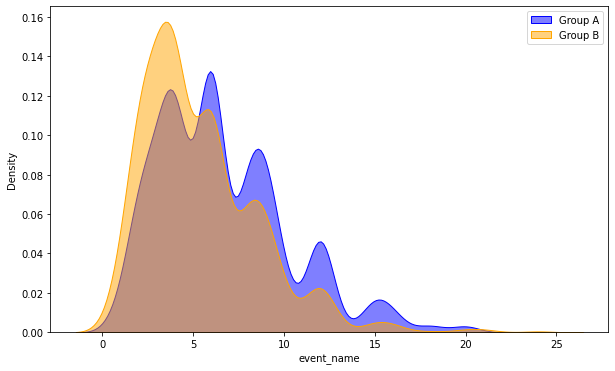

In [57]:
# Plot the kernel density estimate of the number of events per user for both groups
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=group_a_df.groupby('user_id').count()['event_name'], shade=True, alpha=0.5, label='Group A', color='blue')
sns.kdeplot(data=group_b_df.groupby('user_id').count()['event_name'], shade=True, alpha=0.5, label='Group B', color='orange')
plt.legend()
plt.show()



The plot is showing the kernel density estimate of the distribution of events per user for both groups. If the distributions overlap significantly, then the events are likely to be equally distributed between the two groups. On the other hand, if the distributions are significantly different, then the events may not be equally distributed.

**Given all the above results from tests and visualization, I can say that in the two groups, the events are not equally distributed.**

**If the conclusion is that the events are not equally distributed between Group A and Group B, this means that there is a difference in user behavior between the two groups. This could be due to a variety of factors, such as differences in user demographics, the user experience, or the way the groups were assigned**

In terms of an A/B test, this could mean that the test results are not reliable, as the difference in user behavior between the two groups could impact the outcome of the test. If the groups are not balanced in terms of user behavior, it can be difficult to determine if the difference in outcomes is due to the tested variable or the difference in user behavior.

To ensure the reliability of the A/B test, it is important to try to create groups that are as similar as possible in terms of user behavior, demographics, and other relevant factors. 

#### Are there users who enter both samples? 

In [58]:
# Create sets of user IDs for each sample
user_ids_a = set(group_a_df['user_id'])
user_ids_b = set(group_b_df['user_id'])

# Find the intersection of the two sets
user_ids_intersection = user_ids_a.intersection(user_ids_b)

# Print the number of users in the intersection
print(f"Number of users in both samples: {len(user_ids_intersection)}")


Number of users in both samples: 0


In [59]:
# identify unique user IDs in each group
group_a_users = set(recommender_df[recommender_df['group'] == 'A']['user_id'].unique())
group_b_users = set(recommender_df[recommender_df['group'] == 'B']['user_id'].unique())

# find users that are in both groups
users_in_both = group_a_users.intersection(group_b_users)

if len(users_in_both) > 0:
    print(f"There are {len(users_in_both)} users in both groups.")
else:
    print("There are no users in both groups.")


There are no users in both groups.


In [60]:
merged_logs_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...,...,...,...,...,...
429471,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-24 21:55:35,product_page,NaN
429472,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-20 02:23:24,login,NaN
429473,7ADEE837D5D8CBBD,NaN,NaN,2020-12-20,EU,PC,2020-12-24 21:55:35,login,NaN
429474,8F04273BB2860229,NaN,NaN,2020-12-20,EU,Android,2020-12-20 03:17:17,product_cart,NaN


In [61]:
# group the data by user_id and count the number of unique values in the 'ab_test' column
ab_test_count = merged_logs_df.groupby('user_id')['ab_test'].nunique()

# find the users who were in several AB tests at the same time
multi_test_users = ab_test_count[ab_test_count > 1]

if len(multi_test_users) > 0:
    print(f"{len(multi_test_users)} users were in several AB tests at the same time.")
else:
    print("No users were in several AB tests at the same time.")


887 users were in several AB tests at the same time.


In [62]:
# Get all unique user_ids that were in the 'recommender_system_test'
recommender_users = merged_logs_df[merged_logs_df['ab_test'] == 'recommender_system_test']['user_id'].unique()

# Get all unique user_ids that were in other tests
other_tests_users = merged_logs_df[merged_logs_df['ab_test'] != 'recommender_system_test']['user_id'].unique()

# Find the intersection of these two sets to see if any users were in both tests
intersection = set(recommender_users).intersection(set(other_tests_users))

if len(intersection) > 0:
    print(f"{len(intersection)} users were in both the 'recommender_system_test' and another test.")
else:
    print("No users were in both the 'recommender_system_test' and another test.")


887 users were in both the 'recommender_system_test' and another test.


Having users participate in multiple tests simultaneously can potentially affect the results of an A/B test. In this case, if there were 887 users who were in both the 'recommender_system_test' and another test, it means that they may have been exposed to different variations in each test, which can influence their behavior and ultimately affect the results of the 'recommender_system_test'.

In order to address this issue, it's important to try to avoid overlapping tests or to carefully track which users are participating in multiple tests and how their behavior may be influenced by each test variation.


I will not remove those users from my tests, because we already have a much smaller sample from what was designed, and excluding also these users would significantly reduce the sample size.

#### How is the number of events distributed by days?

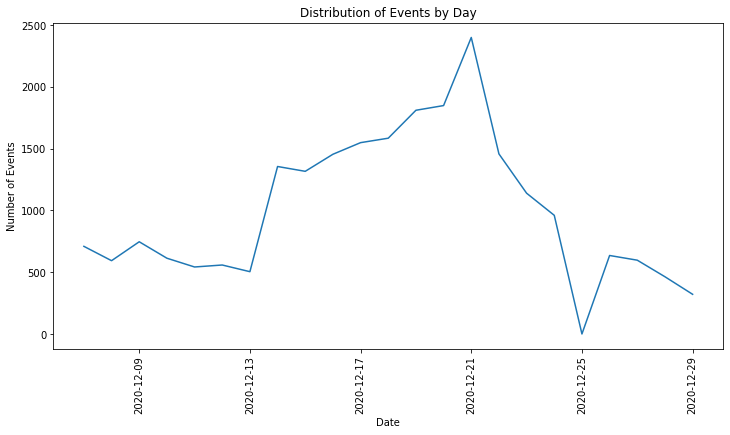

In [63]:
# group the dataframe by date and count the number of events
daily_events = recommender_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# plot the distribution as a line chart
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(daily_events)
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Distribution of Events by Day')
plt.xticks(rotation=90)
plt.show()


In [64]:
group_a_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime,lifetime_days
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06,0
...,...,...,...,...,...,...,...,...,...,...,...
29595,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android,2020-12-11 14:11:37,login,NaN,1 days 14:11:37,1
29599,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac,2020-12-18 19:06:08,login,NaN,0 days 19:06:08,0
29600,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac,2020-12-19 19:58:27,login,NaN,1 days 19:58:27,1
29601,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac,2020-12-20 00:29:37,login,NaN,2 days 00:29:37,2


/tmp/ipykernel_169/3641453867.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



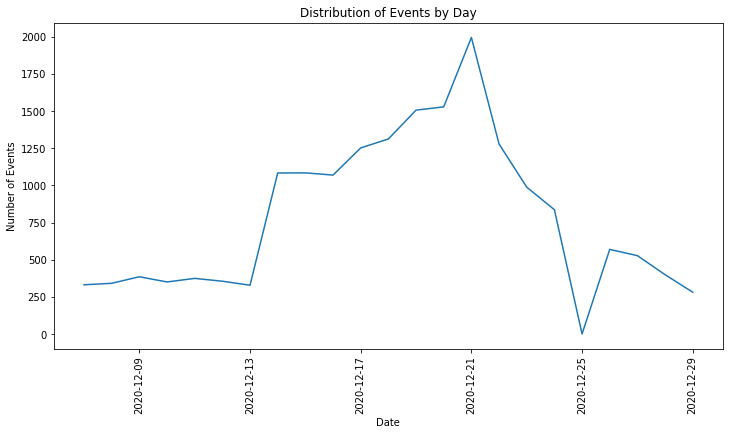

In [65]:

# convert the event_dt column to datetime format
group_a_df['event_dt'] = pd.to_datetime(group_a_df['event_dt'])

# group the dataframe by date and count the number of events
daily_events_a = group_a_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# plot the distribution as a line chart
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(daily_events_a)
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Distribution of Events by Day')
plt.xticks(rotation=90)
plt.show()


/tmp/ipykernel_169/1291104177.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_169/1291104177.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



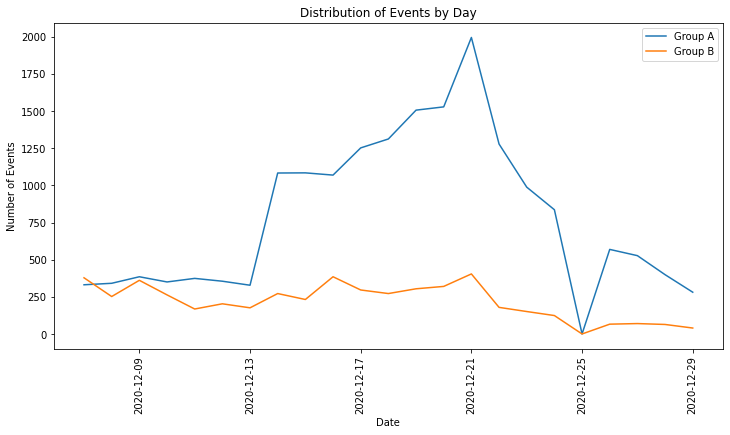

In [66]:
# convert the event_dt column to datetime format for group A
group_a_df['event_dt'] = pd.to_datetime(group_a_df['event_dt'])

# group the dataframe by date and count the number of events for group A
daily_events_a = group_a_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# convert the event_dt column to datetime format for group B
group_b_df['event_dt'] = pd.to_datetime(group_b_df['event_dt'])

# group the dataframe by date and count the number of events for group B
daily_events_b = group_b_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# plot the distribution as a line chart for both groups
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(daily_events_a, label='Group A')
plt.plot(daily_events_b, label='Group B')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Distribution of Events by Day')
plt.xticks(rotation=90)
plt.legend()
plt.show()


For the A group, the number of daily events fluctuate strongly and in general, it has a larger number of daily events compared to the B group, which is consistent with the fact that A is a larger sample.

The t-statistic measures the difference between the means of two groups, while the p-value measures the probability of observing such a difference by chance alone. In this case, the t-test was used to compare the daily event counts for group A and group B.

The t-statistic value indicates how many standard errors the difference between the means is. A higher absolute value of the t-statistic indicates a greater difference between the two means. The p-value indicates the probability of observing the t-statistic value, assuming that there is no difference between the means of the two groups.

If the p-value is less than the chosen significance level (usually 0.05), we can reject the null hypothesis that the means of the two groups are equal, and conclude that there is a statistically significant difference between the two groups. In this case, if the p-value is less than 0.05, we can conclude that there is a significant difference between the daily event counts for group A and group B. If the p-value is greater than 0.05, we cannot reject the null hypothesis, and cannot conclude that there is a significant difference between the two groups.

In [67]:
# Get the daily event counts for each group
daily_events_a = group_a_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()
daily_events_b = group_b_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# Perform the two-sample t-test
t_statistic, p_value = ttest_ind(daily_events_a, daily_events_b, equal_var=False)

# Print the results
print('t-statistic:', t_statistic)
print('p-value:', p_value)

# Interpret the results
if p_value < 0.05:
    print('The difference in daily event counts between groups A and B is statistically significant.')
else:
    print('There is no significant difference in daily event counts between groups A and B.')


t-statistic: 5.126335229866392
p-value: 2.9313136507584393e-05
The difference in daily event counts between groups A and B is statistically significant.


In [68]:
# Get the daily event counts for each group
daily_events_a = group_a_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()
daily_events_b = group_b_df.groupby(pd.Grouper(key='event_dt', freq='D'))['event_name'].count()

# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(daily_events_a, daily_events_b, alternative='two-sided')

# Print the results
print('Mann-Whitney U statistic:', u_statistic)
print('p-value:', p_value)

# Interpret the results
if p_value < 0.05:
    print('There is significant evidence that the two groups have different distributions of events.')
else:
    print('There is not enough evidence to conclude that the two groups have different distributions of events.')


Mann-Whitney U statistic: 474.0
p-value: 4.390529937815394e-06
There is significant evidence that the two groups have different distributions of events.


In [69]:
merged_logs_df.sample(5)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
16023,A834224E54F9BC95,A,recommender_system_test,2020-12-15,EU,PC,2020-12-17 13:30:51,product_page,NaN
109220,737ED2867C72174E,NaN,NaN,2020-12-07,EU,iPhone,2020-12-09 08:23:36,login,NaN
342824,F0CD69CEDB8ED72B,NaN,NaN,2020-12-18,CIS,Android,2020-12-18 15:55:06,login,NaN
428844,A642073B9C52486C,NaN,NaN,2020-12-20,N.America,iPhone,2020-12-21 14:53:21,purchase,4.99
157361,977561BD68EFFDAD,NaN,NaN,2020-12-14,EU,PC,2020-12-23 03:24:51,product_page,NaN


In [70]:
display(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [71]:
# extract start and finish dates of the test from merged_logs_df
start_date = merged_logs_df[merged_logs_df['ab_test'] == 'recommender_system_test']['event_dt'].min().date()
finish_date = merged_logs_df[merged_logs_df['ab_test'] == 'recommender_system_test']['event_dt'].max().date()

# check for any overlapping marketing events
overlapping_events = marketing_events[(marketing_events['start_dt'] <= pd.Timestamp(finish_date)) & (marketing_events['finish_dt'] >= pd.Timestamp(start_date))]

if len(overlapping_events) > 0:
    print("There were overlapping marketing events:")
    print(overlapping_events)
else:
    print("There were no overlapping marketing events.")


There were overlapping marketing events:
                         name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07


It means that the A/B test results may be affected by the marketing events that took place during the same time period. The overlapping marketing events could have impacted user behavior and skewed  test results.

Let's see if in the final dataframe I am using for the analysis, there are users with overlapping marketing events( since I filtered by 14 days from sign up)

In [72]:
# extract start and finish dates of the test from test_results_df
start_date = recommender_df['first_date'].min().date()
finish_date = recommender_df['first_date'].max().date()

# check for any overlapping marketing events
overlapping_events = marketing_events[(marketing_events['start_dt'] <= pd.Timestamp(finish_date)) & (marketing_events['finish_dt'] >= pd.Timestamp(start_date))]

if len(overlapping_events) > 0:
    print("There were overlapping marketing events:")
    print(overlapping_events)
else:
    print("There were no overlapping marketing events.")



There were no overlapping marketing events.


### AB TEST

In [73]:
recommender_df

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime,lifetime_days
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06,0
...,...,...,...,...,...,...,...,...,...,...,...
29619,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,login,NaN,0 days 10:12:15,0
29620,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,login,NaN,1 days 22:51:16,1
29621,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,login,NaN,2 days 02:28:03,2
29622,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,login,NaN,3 days 22:55:14,3


In [74]:
recommender_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23151 entries, 0 to 29623
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   user_id        23151 non-null  object         
 1   group          23151 non-null  object         
 2   ab_test        23151 non-null  object         
 3   first_date     23151 non-null  datetime64[ns] 
 4   region         23151 non-null  object         
 5   device         23151 non-null  object         
 6   event_dt       23151 non-null  datetime64[ns] 
 7   event_name     23151 non-null  object         
 8   details        3125 non-null   float64        
 9   lifetime       23151 non-null  timedelta64[ns]
 10  lifetime_days  23151 non-null  int64          
dtypes: datetime64[ns](2), float64(1), int64(1), object(6), timedelta64[ns](1)
memory usage: 2.6+ MB


create a 'cohorts' column by grouping the users based on their 'group' and 'first_date'

In [75]:
recommender_df['cohorts'] = recommender_df.groupby(['group', pd.Grouper(key='first_date', freq='1D')])['user_id'].transform('nunique')



/tmp/ipykernel_169/2021602433.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This line of code is adding a new column called "cohorts". The "cohorts" column will contain the number of unique users who belong to a specific group and signed up on a particular date.



In [76]:
# print the result
print(recommender_df[['group', 'first_date', 'cohorts']].drop_duplicates())

     group first_date  cohorts
0        A 2020-12-07      163
4        A 2020-12-20      274
8        A 2020-12-08       98
14       A 2020-12-14      387
50       A 2020-12-16      169
54       A 2020-12-17      212
60       A 2020-12-09       82
78       B 2020-12-21       93
84       A 2020-12-18      220
90       A 2020-12-19      239
92       B 2020-12-17       39
105      B 2020-12-07      182
117      A 2020-12-21      417
159      A 2020-12-12       64
180      A 2020-12-15      208
286      B 2020-12-14       72
296      B 2020-12-16       99
306      B 2020-12-09       85
327      B 2020-12-20       63
376      B 2020-12-08       44
384      B 2020-12-19       47
592      A 2020-12-11       92
660      B 2020-12-18       50
765      A 2020-12-10       66
866      B 2020-12-15       32
925      B 2020-12-10       33
1312     A 2020-12-13       56
1801     B 2020-12-11       21
1826     B 2020-12-13       15
3103     B 2020-12-12       53


In [77]:
recommender_df.head(10)


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime,lifetime_days,cohorts
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0 days 14:43:27,0,163
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0 days 14:43:29,0,163
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0 days 14:43:27,0,163
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0 days 14:43:27,0,163
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0 days 15:46:06,0,274
5,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-21 00:40:59,product_page,NaN,1 days 00:40:59,1,274
6,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:02,login,NaN,0 days 15:46:02,0,274
7,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-21 00:40:58,login,NaN,1 days 00:40:58,1,274
8,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,2020-12-08 11:30:58,login,NaN,0 days 11:30:58,0,98
9,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,2020-12-11 12:52:32,login,NaN,3 days 12:52:32,3,98


In [78]:
recommender_df.cohorts.nunique()

30

In [79]:
recommender_df[['group', 'first_date', 'cohorts']].drop_duplicates().sort_values(by='cohorts')

,group,first_date,cohorts
1826,B,2020-12-13,15
1801,B,2020-12-11,21
866,B,2020-12-15,32
925,B,2020-12-10,33
92,B,2020-12-17,39
376,B,2020-12-08,44
384,B,2020-12-19,47
660,B,2020-12-18,50
3103,B,2020-12-12,53
1312,A,2020-12-13,56


In [80]:
recommender_df[['group', 'first_date', 'cohorts']].drop_duplicates().sort_values(by='first_date')

,group,first_date,cohorts
0,A,2020-12-07,163
105,B,2020-12-07,182
8,A,2020-12-08,98
376,B,2020-12-08,44
60,A,2020-12-09,82
306,B,2020-12-09,85
925,B,2020-12-10,33
765,A,2020-12-10,66
1801,B,2020-12-11,21
592,A,2020-12-11,92


In [81]:
recommender_df.event_dt.max()

Timestamp('2020-12-29 23:38:29')

We should test if within 14 days of signing up, users will show better conversion into product page views, but, given this data, we cannot evaluate the cohorts from date 16 december, within 14 days, cause we don't have enough information.

+ The first dates of activity for the cohorts range from December 7 to December 21, 2020.

- There does not appear to be a consistent pattern or trend in the size of the cohorts and the first date of activity.

In the context of an A/B testing, the lack of a clear pattern or trend in the size of the cohorts and the first date of activity could potentially be a problem. This is because a key assumption of A/B testing is that the tested and control groups are similar in terms of their characteristics and behavior, except for the one variable being tested. If there are systematic differences in the characteristics or behavior of the groups that are not related to the test variable, it can introduce bias and make it difficult to interpret the results of the test.

In particular, if there is no clear relationship between the size of the cohorts and the first date of activity, it may be more difficult to ensure that the tested and control groups are balanced in terms of these variables. For example, if one cohort has a much larger size or earlier first date of activity than the other, it could bias the results of the test in favor of one group or the other.



I cannot fully evaluate the cohorts from December 16 to December 30 (which is the full 14-day period for those cohorts), but I can still conduct the A/B test using the data available. However, it would be important to ensure that the test is conducted in a way that accounts for the fact that the full 14-day period is not available for all cohorts.

One possible approach could be to compare the conversion rates between the test and control groups for the period of time that is available for all cohorts, which is from December 7 to December 30. 

Define the null and alternative hypotheses

In [82]:
null_hypothesis = "The conversion rates in group B are the same or lower than the conversion rates in group A."
alternative_hypothesis = "The conversion rates in group B are higher than the conversion rates in group A by at least 10%."


Set the significance level (alpha) to 0.05 and apply the bonferroni correction

In [83]:
# Set the significance level and number of tests
alpha = 0.05
num_tests = 3

# Compute the number of successes and trials in each group for each stage of the funnel within the first 14 days
for stage in ['product_page', 'product_cart', 'purchase']:
    
    group_a_successes = recommender_df[(recommender_df['group'] == 'A') & (recommender_df['event_name'] == stage) & (recommender_df['event_dt'] <= recommender_df['first_date'] + timedelta(days=14))].shape[0]
    group_a_trials = recommender_df[(recommender_df['group'] == 'A') & (recommender_df['event_dt'] <= recommender_df['first_date'] + timedelta(days=14))].shape[0]
    group_b_successes = recommender_df[(recommender_df['group'] == 'B') & (recommender_df['event_name'] == stage) & (recommender_df['event_dt'] <= recommender_df['first_date'] + timedelta(days=14))].shape[0]
    group_b_trials = recommender_df[(recommender_df['group'] == 'B') & (recommender_df['event_dt'] <= recommender_df['first_date'] + timedelta(days=14))].shape[0]

    # Compute the pooled proportion and standard error
    pooled_prop = (group_a_successes + group_b_successes) / (group_a_trials + group_b_trials)
    se = np.sqrt(pooled_prop * (1 - pooled_prop) * ((1 / group_a_trials) + (1 / group_b_trials)))

    # Compute the z-score and p-value
    z_score = (group_b_successes / group_b_trials - group_a_successes / group_a_trials) / se
    p_value = 1 - proportions_ztest(count=[group_b_successes, group_a_successes], nobs=[group_b_trials, group_a_trials], value=0, alternative='larger')[1]

    # Check if the p-value is less than adjusted alpha
    if p_value < alpha/num_tests:
        print(f"At the {stage} stage of the funnel within the first 14 days, the null hypothesis can be rejected with a p-value of {p_value:.2f}.")
        print(alternative_hypothesis)
    else:
        print(f"At the {stage} stage of the funnel within the first 14 days, the null hypothesis cannot be rejected with a p-value of {p_value:.2f}.")
        print(null_hypothesis)


At the product_page stage of the funnel within the first 14 days, the null hypothesis can be rejected with a p-value of 0.00.
The conversion rates in group B are higher than the conversion rates in group A by at least 10%.
At the product_cart stage of the funnel within the first 14 days, the null hypothesis cannot be rejected with a p-value of 0.23.
The conversion rates in group B are the same or lower than the conversion rates in group A.
At the purchase stage of the funnel within the first 14 days, the null hypothesis can be rejected with a p-value of 0.02.
The conversion rates in group B are higher than the conversion rates in group A by at least 10%.


This block of code (compares the conversion rates of the control and test groups for each stage of the funnel. It then calculates the difference in conversion rates between the two groups and checks if it is statistically significant. Additionally, it checks if there is a 10% increase in conversion rates from the product_cart to purchase stage and from the product_page to product_cart stage.

# conclusions

The Results of the test tells us that the changes about a new payment funnel, do make a difference: within 14 days from sign up we assist to an increase of 10% or higher in conversion rate.


However, given my findings during the EDA, I must state that the results of the test might not be reliable. 
In particular, I found out that the technical requirement for the test were not fully met, so the test was executed with many aspect which differs from how the test was originally designed:

+ Audience: 9.73% of the new users from the EU region, instead of the designed 15%
+ Actual number of participants: 3675 vs Expected number of test participants: 6000
+ End date: 30 Dec 2020 instead of 1-1-2021
+ Sizes of groups A and B are not equal
+ Events per users daily are not equally distributed between the groups
+ 887 users took part in another test at the same time
+ we don't have 14 days of data available for all users
+ marketing events overlapped with the designed time for the A/B test


These deviations from the original design may have introduced biases and confounding factors that can affect the accuracy and validity of the results.

For example, the unequal size of groups A and B can introduce sampling bias, which can skew the results in favor of the larger group. The unequal distribution of events per user daily between groups can introduce measurement bias, which can affect the accuracy of the measurements.

Moreover, not having 14 days of data available for all users can affect the statistical power of the test. The shorter time frame may not provide enough data to detect small changes in conversion rates, and the data may be more variable, making it harder to detect significant differences between the groups.

Overall, these deviations from the original design of the test can undermine the reliability of the results, and it's important to consider them when interpreting the results of the test.